## Online Retail DataSet

## Introduction:

In recent years, online shopping has grown from non-existent to a multibillion-dollar industry. Buying products online has become a regular among millions of peoples. In 2019 eCommerce comprises more than 14.2% of global retail revenue also it is estimated there will be 1.92 billion global digital buyers.  The reason behind the growth of online shopping is the service and experience provided by businesses. We could see a lot of new features provided by businesses to retain buyers and their online shopping experience. Businesses use the recommendation system to improve the buyer's shopping experience. The recommendation system works based on the products purchased or buyer interest by their history of transactions. I have an online retail dataset which consists of 8 columns with a detailed transnational data occurred between 2010 to 2011 for a lot of countries based on this dataset I am going to recommend the top 10 products for each selected product. To recommend products I am going to use KNN, Cosine similarity, Pearson correlation coefficient, and Matrix factorization.

## Research Objective:

Improving recommendation system based on seasonal products.

## Problem Statement:

While purchasing products online we could see a lot of recommendations related to a product. Mostly all the recommendations are based on throughout the year there won't be any separate recommendation for seasonal products. For example, a seasonal product like a winter coat could not be recommended to a customer in summer. My goal is to recommend products based on the season through which we can improve sales and also attracts buyers to continue their shopping experience happily.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

Importing online retai dataset. (src: https://archive.ics.uci.edu/ml/datasets/Online+Retail) 

In [2]:
data=pd.read_excel('Online Retail.xlsx')

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Removing unspecified country from the dataset.

In [4]:
data = data[data.Country != 'Unspecified']

Removing unwanted spaces from description column

In [5]:
data['Description'] = data['Description'].str.strip()

Removed quantity which are less than 0

In [6]:
data = data.loc[data['Quantity'] > 0]

Removed rows without customer Id

In [7]:
data.loc[data['CustomerID'].isna()].head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom


In [8]:
df = data.dropna(subset=['CustomerID'])

Removing the rows that don’t have invoice numbers and credit transactions

In [9]:
df.dropna(axis=0, subset=['InvoiceNo'], inplace=True)
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df = df[~df['InvoiceNo'].str.contains('C')]
df=df[df['StockCode'].astype(str).str.isdigit()]


C:\Users\Vinoth Shankar\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Vinoth Shankar\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
Cols=df.columns

In [11]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

Splitting the dataset into season wise

In [12]:
SpringDataSet=pd.DataFrame(columns=Cols)
for i in range(3,6):
    a=df[df['InvoiceDate'].dt.month == i]
    SpringDataSet=SpringDataSet.append(a) 

In [13]:
SummerDataSet=pd.DataFrame(columns=Cols)
for i in range(6,9):
    a=df[df['InvoiceDate'].dt.month == i]
    SummerDataSet=SummerDataSet.append(a)

In [14]:
AutumnDataSet=pd.DataFrame(columns=Cols)
for i in range(9,12):
    a=df[df['InvoiceDate'].dt.month == i]
    AutumnDataSet=AutumnDataSet.append(a)

In [15]:
WinterDataSet=df[df['InvoiceDate'].dt.month == 12]
for i in range(1,3):
    a=df[df['InvoiceDate'].dt.month == i]
    WinterDataSet=WinterDataSet.append(a)

## Data Visualization

### Plot 1

The plot clearly explains the total number of quantities sold during a particular period. Also, it shows what are the top products sold during that period. We could see in all the plots stock code between 20000 to 25000 as the most number of sales. Also, we could see on a specific period certain stock code as high sales.


In [16]:
def TopProducts(dataset):
    productsSelled = dataset.groupby(by=['StockCode'], as_index=False)['Quantity'].sum()
    plt.subplots(figsize=(15,6))
    plt.plot(productsSelled.StockCode, productsSelled.Quantity)
    plt.xlabel('Stock Code')
    plt.ylabel('Quantity')
    plt.show()    

#### Overall Sales Data:

The plot shows the total products sold throughout the year. Here, we could see the stock code between 20000 to 25000 as top sales and also stock near to 85000 as good sales

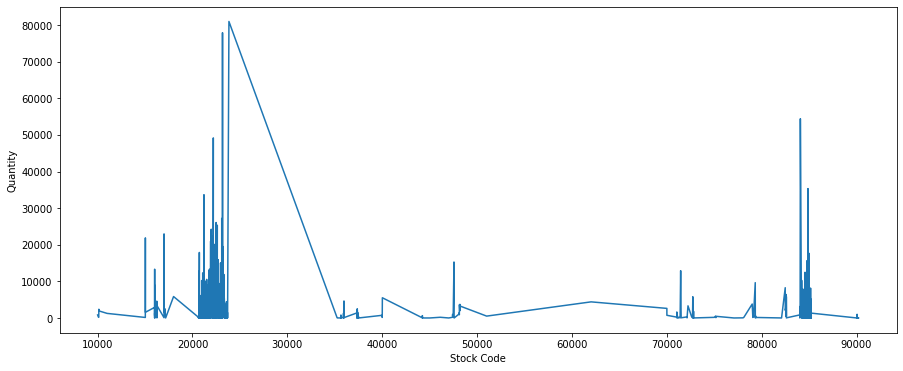

In [17]:
TopProducts(df)

#### Spring Sales Data:

In spring season we could stock code near to 85000 as top sales on comparing with overall sales.

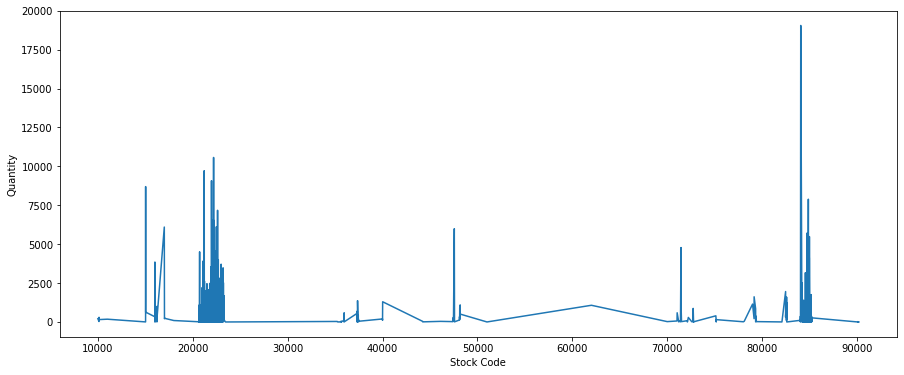

In [18]:
TopProducts(SpringDataSet)

#### Summer Sales Data:

Here we could see stock code ranging between 15000 to 25000 and stock code near to 85000 as an equal number of sales. Also stock code near to 50000 as significant raise.

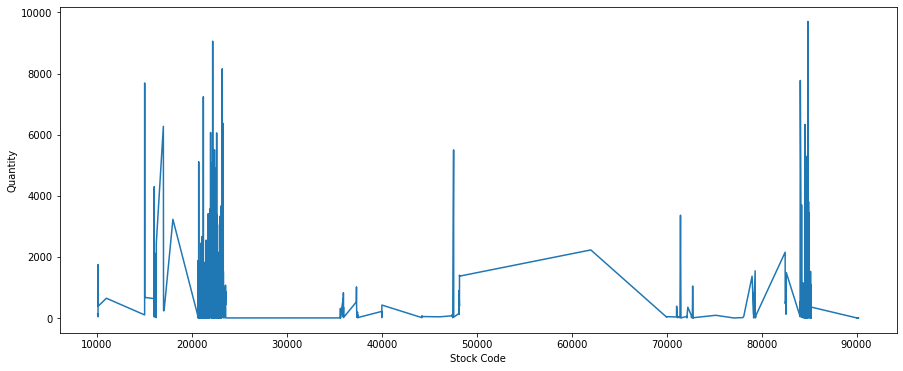

In [19]:
TopProducts(SummerDataSet)

#### Autumn Sales Data:

As usual we could see stock code near to 20000 and 85000 as most sales.
    

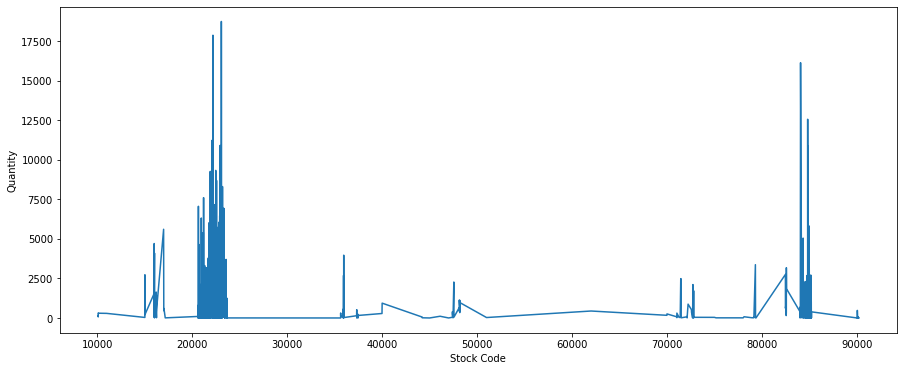

In [20]:
TopProducts(AutumnDataSet)

#### Winter Sales Data:
    
We could see the sales itself low during winter season except few stock code near to 25000

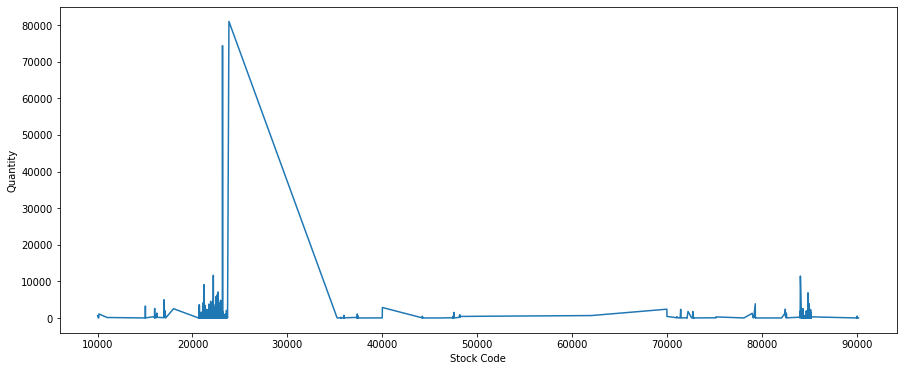

In [21]:
TopProducts(WinterDataSet)

### Plot 2:

The Plot shows the unit price for different products. We could see from time to time a few products were given for free.

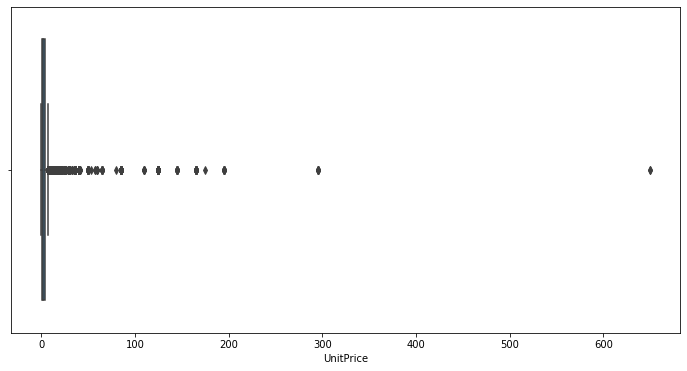

In [22]:
plt.subplots(figsize=(12,6))
sns.boxplot(df.UnitPrice)
plt.show()

Pivot Table

In [23]:
SpringCustomMatrix = SpringDataSet.pivot_table(index='CustomerID',columns='StockCode',values='Quantity',aggfunc='sum')

In [24]:
SummerCustomMatrix = SummerDataSet.pivot_table(index='CustomerID',columns='StockCode',values='Quantity',aggfunc='sum')

In [25]:
AutumnCustomMatrix = AutumnDataSet.pivot_table(index='CustomerID',columns='StockCode',values='Quantity',aggfunc='sum')

In [26]:
WinterCustomMatrix = WinterDataSet.pivot_table(index='CustomerID',columns='StockCode',values='Quantity',aggfunc='sum')

In [27]:
DfCustomMatrix=df.pivot_table(index='CustomerID',columns='StockCode',values='Quantity',aggfunc='sum')

Converting units anything greater than zero as one else zero

In [28]:
SpringCustomMatrix = SpringCustomMatrix.applymap(lambda x: x if x>0 else 0)
SummerCustomMatrix = SummerCustomMatrix.applymap(lambda x: x if x>0 else 0)
AutumnCustomMatrix = AutumnCustomMatrix.applymap(lambda x: x if x>0 else 0)
WinterCustomMatrix = WinterCustomMatrix.applymap(lambda x: x if x>0 else 0)
DfCustomMatrix = DfCustomMatrix.applymap(lambda x: x if x>0 else 0)

## Algorithms

Following are the three mainly used Recommendation systems,

Collaborative filtering,
Content Based filtering,
Hybrid Recommendation system

### Collaborative based filtering:

Collaborative filtering requires data collection and analysis of the behaviors and preferences of customers to identify patterns and provide accurate recommendations based on similarity to other users. It can be classified into be user-based or item-based recommendation.

### Content Based filtering:

Content-based filtering focuses on the object's attributes or descriptive properties. It creates a model based on past behaviors of a user (items previously purchased or selected and/or numerical ratings given to those items) and similar decisions made by other users

### Hybrid Recommendation System:

The combination of the two approaches utilized here. Most businesses are likely to use hybrid approach in their recommender systems for production.


### K-Nearest Neighbour using Euclidean

KNN is a perfect go-to model for implementing item-based collaborative filtering, and also a very good basis for recommending system development. It makes inferences about a stock code, KNN calculates the "distance" between the target stock code and any other stock code in its data frame, then ranks its distances and returns the nearest neighboring top K stock code as recommendations for the most similar stock code. I have used euclidean distance as a distance metric to find its distance between the recommended products.

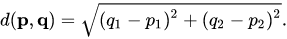

The recommended stock code does not match with each other datasets. Also, we could see the distance for an overall dataset is doubled that of the distance of seasonal dataset.

In [29]:
def knnRecommend(StockCode,DataSet):
    CustomMatrix = DataSet.pivot_table(index='StockCode',columns='CustomerID',values='Quantity',aggfunc='sum')
    CustomMatrix = CustomMatrix.applymap(lambda x: 1 if x>0 else 0)
    dfMatrix = csr_matrix(CustomMatrix.values)
    model_knn = NearestNeighbors()
    model_knn.fit(dfMatrix)
    sre=CustomMatrix
    sre = CustomMatrix.reset_index()
    query_index =sre.loc[sre['StockCode'] == StockCode].index.values.astype(int)[0]
    distances, indices = model_knn.kneighbors(CustomMatrix.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 11)
    for i in range(0, len(distances.flatten())):
        if i == 0:
            print('Recommendations for {0}:\n'.format(CustomMatrix.index[query_index]))
        else:
            print('{0}: {1}, with distance of {2}:'.format(i, CustomMatrix.index[indices.flatten()[i]], distances.flatten()[i]))

    
    
    

#### Overall Dataset

In [30]:
knnRecommend(11001,df)

Recommendations for 11001:

1: 90103, with distance of 6.48074069840786:
2: 90169, with distance of 6.557438524302:
3: 90101, with distance of 6.557438524302:
4: 20678, with distance of 6.557438524302:
5: 21785, with distance of 6.557438524302:
6: 16010, with distance of 6.557438524302:
7: 90076, with distance of 6.557438524302:
8: 90168, with distance of 6.557438524302:
9: 90104, with distance of 6.557438524302:
10: 90118, with distance of 6.557438524302:


#### Spring Dataset

In [31]:
knnRecommend(11001,SpringDataSet)

Recommendations for 11001:

1: 20906, with distance of 3.1622776601683795:
2: 20670, with distance of 3.3166247903554:
3: 22952, with distance of 3.3166247903554:
4: 84522, with distance of 3.3166247903554:
5: 21698, with distance of 3.3166247903554:
6: 22182, with distance of 3.3166247903554:
7: 20897, with distance of 3.4641016151377544:
8: 21897, with distance of 3.4641016151377544:
9: 21357, with distance of 3.4641016151377544:
10: 37343, with distance of 3.4641016151377544:


#### Summer Dataset

In [32]:
knnRecommend(11001,SummerDataSet)

Recommendations for 11001:

1: 84226, with distance of 3.4641016151377544:
2: 84827, with distance of 3.4641016151377544:
3: 21351, with distance of 3.4641016151377544:
4: 72131, with distance of 3.4641016151377544:
5: 72134, with distance of 3.4641016151377544:
6: 22647, with distance of 3.4641016151377544:
7: 90103, with distance of 3.4641016151377544:
8: 22108, with distance of 3.4641016151377544:
9: 22934, with distance of 3.4641016151377544:
10: 84658, with distance of 3.4641016151377544:


#### Autumn Dataset

In [33]:
knnRecommend(11001,AutumnDataSet)

Recommendations for 11001:

1: 20619, with distance of 4.0:
2: 90043, with distance of 4.123105625617661:
3: 72812, with distance of 4.123105625617661:
4: 90032, with distance of 4.123105625617661:
5: 21725, with distance of 4.123105625617661:
6: 90049, with distance of 4.123105625617661:
7: 90086, with distance of 4.123105625617661:
8: 84813, with distance of 4.123105625617661:
9: 84497, with distance of 4.123105625617661:
10: 90146, with distance of 4.123105625617661:


#### Winter Dataset

In [34]:
knnRecommend(11001,WinterDataSet)

Recommendations for 11001:

1: 22687, with distance of 3.0:
2: 90167, with distance of 3.0:
3: 78124, with distance of 3.0:
4: 20653, with distance of 3.0:
5: 21293, with distance of 3.0:
6: 72812, with distance of 3.0:
7: 23038, with distance of 3.0:
8: 23088, with distance of 3.1622776601683795:
9: 90119, with distance of 3.1622776601683795:
10: 85095, with distance of 3.1622776601683795:


### Collaborative Filtering Using Cosine Similarity

Cosine similarity is simply one of the most common metrics used to find the recommendation. It will measure the similarity between these two vectors, which is a measure of how similar these two people's preferences are. Mathematically, if ‘a’ and ‘b’ are two vectors, the cosine equation gives the angle between the two.

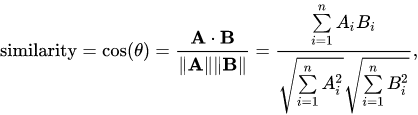

We could see the overall dataset as a better similarity than the other dataset. Most of the similarity are ranging from 0.8 to 0.95 while for other dataset ranges from 0.2 to 0.3

In [100]:
def CollaborativeFiltering(customMatrix,dataset):
    ItemMatrix = pd.DataFrame(cosine_similarity(customMatrix.T))
    ItemMatrix.columns = customMatrix.T.index
    ItemMatrix['StockCode'] = customMatrix.T.index
    ItemMatrix = ItemMatrix.set_index('StockCode')
    cosine_df = pd.DataFrame(ItemMatrix.loc[11001].sort_values(ascending=False).iloc[:11])
    cosine_df.reset_index(level=0, inplace=True)
    cosine_df.columns = ['StockCode','CosineSim']
    result =pd.merge(cosine_df, dataset, on='StockCode', how='inner')[['StockCode','Description','CosineSim']];
    print(result.drop_duplicates().set_index('StockCode'))
    

#### Overall Dataset

In [101]:
CollaborativeFiltering(DfCustomMatrix,df)

                                Description  CosineSim
StockCode                                             
11001           ASSTD DESIGN RACING CAR PEN   1.000000
23215      JINGLE BELL HEART ANTIQUE SILVER   0.942476
22191                IVORY DINER WALL CLOCK   0.931216
22493             PAINT YOUR OWN CANVAS SET   0.920351
22991                  GIRAFFE WOODEN RULER   0.911492
21479          WHITE SKULL HOT WATER BOTTLE   0.892183
22604        SET OF 4 NAPKIN CHARMS CUTLERY   0.866970
20829      GLITTER HANGING BUTTERFLY STRING   0.857509
84879         ASSORTED COLOUR BIRD ORNAMENT   0.835437
22992                 REVOLVER WOODEN RULER   0.814174
22564                ALPHABET STENCIL CRAFT   0.802365


#### Spring Dataset

In [102]:
CollaborativeFiltering(SpringCustomMatrix,SpringDataSet)

                                   Description  CosineSim
StockCode                                                
11001              ASSTD DESIGN RACING CAR PEN   1.000000
21643             ASSORTED TUTTI FRUTTI MIRROR   0.482418
71270                          PHOTO CLIP LINE   0.462137
20670                        VIP HOLIDAY PURSE   0.461280
22808          SET OF 6 T-LIGHTS EASTER CHICKS   0.450601
21642                ASSORTED TUTTI FRUTTI PEN   0.358353
21640      ASSORTED TUTTI FRUTTI  FOB NOTEBOOK   0.321736
85172            HYACINTH BULB T-LIGHT CANDLES   0.297755
20941                              FROG CANDLE   0.280150
22438        BALLOON ART MAKE YOUR OWN FLOWERS   0.274786
20906             VINTAGE NOTEBOOK BEAUTY GIRL   0.257863


#### Summer Dataset

In [103]:
CollaborativeFiltering(SummerCustomMatrix, SummerDataSet)

                                  Description  CosineSim
StockCode                                               
11001             ASSTD DESIGN RACING CAR PEN   1.000000
22564                  ALPHABET STENCIL CRAFT   0.991130
21479            WHITE SKULL HOT WATER BOTTLE   0.991087
23215        JINGLE BELL HEART ANTIQUE SILVER   0.989113
22191                  IVORY DINER WALL CLOCK   0.987246
22991                    GIRAFFE WOODEN RULER   0.986737
22493               PAINT YOUR OWN CANVAS SET   0.984587
20829        GLITTER HANGING BUTTERFLY STRING   0.982085
84879           ASSORTED COLOUR BIRD ORNAMENT   0.975151
21430      SET/3 RED GINGHAM ROSE STORAGE BOX   0.969398
22561             WOODEN SCHOOL COLOURING SET   0.968940


#### Autumn Dataset

In [89]:
CollaborativeFiltering(AutumnCustomMatrix,AutumnDataSet)

                                Description  CosineSim
StockCode                                             
11001           ASSTD DESIGN RACING CAR PEN   1.000000
22422                   TOOTHPASTE TUBE PEN   0.245045
21056                 DOCTOR'S BAG SOFT TOY   0.232167
20619               TROPICAL PASSPORT COVER   0.226073
84813         SET OF 4 DIAMOND NAPKIN RINGS   0.218116
10135          COLOURING PENCILS BROWN TUBE   0.216506
90086              CRYSTAL FROG PHONE CHARM   0.207750
20662             FIRST CLASS HOLIDAY PURSE   0.207750
90093        CLEAR CRYSTAL STAR PHONE CHARM   0.207750
20663      QUEEN OF THE SKIES HOLIDAY PURSE   0.207750
90049            IVORY GOLD METAL BAG CHARM   0.207750


#### Winter Dataset

In [90]:
CollaborativeFiltering(WinterCustomMatrix,WinterDataSet)

                               Description  CosineSim
StockCode                                            
11001          ASSTD DESIGN RACING CAR PEN   1.000000
90167      BEADED LOVE HEART JEWELLERY SET   0.631101
78124         MAGAZINE RACK GEBRA ASSORTED   0.315551
21557               SET OF 6 FUNKY BEAKERS   0.312740
20830                   SILVER PHOTO FRAME   0.309175
21197        MULTICOLOUR  CONFETTI IN TUBE   0.289516
22449             SILK PURSE BABUSHKA PINK   0.218347
21832                 CHOCOLATE CALCULATOR   0.215876
22940            FELTCRAFT CHRISTMAS FAIRY   0.211357
22869         NUMBER TILE COTTAGE GARDEN 1   0.195932
22872         NUMBER TILE COTTAGE GARDEN 4   0.194185


### Pearson correlation coefficient algorithm

A Pearson correlation is a -1 to 1 number indicating the extent to which two variables are linearly related. The Pearson correlation is also known as the "coefficient of correlation of the moment of the product" (PMCC) or simply "correlation."


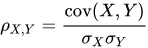

Here also the overall and summer dataset as better correlation than other datasets but the recommended products doesn't match with each other

In [97]:
def recommend(StockCode,CustomMatrix,sDataset):
    print("For StockCode ({})".format(StockCode))
    print("- Top 10 Products recommended based on Pearsons'R correlation - ")
    target = CustomMatrix[StockCode]
    similar_to_target = CustomMatrix.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target,columns=['Correlation'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.reset_index()
    corr_target = corr_target.sort_values('Correlation', ascending = False)
    result =pd.merge(corr_target, sDataset, on='StockCode', how='inner')[['StockCode','Description','Correlation']];
    result=result.drop_duplicates()
    print(result.head(11))

#### Overall Dataset

In [98]:
recommend(11001,DfCustomMatrix,df)

For StockCode (11001)
- Top 10 Products recommended based on Pearsons'R correlation - 
     StockCode                       Description  Correlation
0        11001       ASSTD DESIGN RACING CAR PEN     1.000000
64       23215  JINGLE BELL HEART ANTIQUE SILVER     0.942391
267      22191            IVORY DINER WALL CLOCK     0.931122
668      22493         PAINT YOUR OWN CANVAS SET     0.920232
848      22991              GIRAFFE WOODEN RULER     0.911352
1089     21479      WHITE SKULL HOT WATER BOTTLE     0.892067
1480     22604    SET OF 4 NAPKIN CHARMS CUTLERY     0.866787
1592     20829  GLITTER HANGING BUTTERFLY STRING     0.857290
1761     84879     ASSORTED COLOUR BIRD ORNAMENT     0.836037
3166     22992             REVOLVER WOODEN RULER     0.813873
3462     22564            ALPHABET STENCIL CRAFT     0.802144


 #### Spring Dataset

In [99]:
recommend(11001,SpringCustomMatrix,SpringDataSet)

For StockCode (11001)
- Top 10 Products recommended based on Pearsons'R correlation - 
   StockCode                          Description  Correlation
0      11001          ASSTD DESIGN RACING CAR PEN     1.000000
11     21643         ASSORTED TUTTI FRUTTI MIRROR     0.480862
17     71270                      PHOTO CLIP LINE     0.460970
23     20670                    VIP HOLIDAY PURSE     0.460503
25     22808      SET OF 6 T-LIGHTS EASTER CHICKS     0.448106
46     21642            ASSORTED TUTTI FRUTTI PEN     0.356871
51     21640  ASSORTED TUTTI FRUTTI  FOB NOTEBOOK     0.319717
57     85172        HYACINTH BULB T-LIGHT CANDLES     0.294771
67     20941                          FROG CANDLE     0.277679
75     22438    BALLOON ART MAKE YOUR OWN FLOWERS     0.271241
89     20906         VINTAGE NOTEBOOK BEAUTY GIRL     0.257009


#### Summer Dataset

In [94]:
recommend(11001,SummerCustomMatrix,SummerDataSet)

For StockCode (11001)
- Top 10 Products recommended based on Pearsons'R correlation - 
    StockCode                         Description  Correlation
0       11001         ASSTD DESIGN RACING CAR PEN     1.000000
15      22564              ALPHABET STENCIL CRAFT     0.991127
51      21479        WHITE SKULL HOT WATER BOTTLE     0.991091
69      23215    JINGLE BELL HEART ANTIQUE SILVER     0.989113
85      22191              IVORY DINER WALL CLOCK     0.987235
169     22991                GIRAFFE WOODEN RULER     0.986723
210     22493           PAINT YOUR OWN CANVAS SET     0.984575
248     20829    GLITTER HANGING BUTTERFLY STRING     0.982069
284     84879       ASSORTED COLOUR BIRD ORNAMENT     0.975410
570     21430  SET/3 RED GINGHAM ROSE STORAGE BOX     0.969412
634     22561         WOODEN SCHOOL COLOURING SET     0.969014


#### Autumn Dataset

In [104]:
recommend(11001,AutumnCustomMatrix,AutumnDataSet)

For StockCode (11001)
- Top 10 Products recommended based on Pearsons'R correlation - 
    StockCode                          Description  Correlation
0       11001          ASSTD DESIGN RACING CAR PEN     1.000000
27      22422                  TOOTHPASTE TUBE PEN     0.241947
68      21056                DOCTOR'S BAG SOFT TOY     0.230268
83      20619              TROPICAL PASSPORT COVER     0.224647
90      84813        SET OF 4 DIAMOND NAPKIN RINGS     0.217113
93      10135         COLOURING PENCILS BROWN TUBE     0.212833
131     90032           IVORY SHELL HEART NECKLACE     0.206993
132     90146  FINE SILVER NECKLACE W PASTEL FLOWE     0.206993
133     72812        LARGE ZINC GLASS CANDLEHOLDER     0.206993
134     90083      CRYSTAL CZECH CROSS PHONE CHARM     0.206993
137     20662            FIRST CLASS HOLIDAY PURSE     0.206993


#### Winter Dataset

In [96]:
recommend(11001,WinterCustomMatrix,WinterDataSet)

For StockCode (11001)
- Top 10 Products recommended based on Pearsons'R correlation - 
    StockCode                      Description  Correlation
0       11001      ASSTD DESIGN RACING CAR PEN     1.000000
11      90167  BEADED LOVE HEART JEWELLERY SET     0.631033
12      78124     MAGAZINE RACK GEBRA ASSORTED     0.314851
13      21557           SET OF 6 FUNKY BEAKERS     0.311608
30      20830               SILVER PHOTO FRAME     0.307079
37      21197    MULTICOLOUR  CONFETTI IN TUBE     0.288052
42      22449         SILK PURSE BABUSHKA PINK     0.213531
77      21832             CHOCOLATE CALCULATOR     0.211850
107     22940        FELTCRAFT CHRISTMAS FAIRY     0.205746
182     22869     NUMBER TILE COTTAGE GARDEN 1     0.193965
187     22872     NUMBER TILE COTTAGE GARDEN 4     0.192145


### Matrix Factorization

Matrix factorization is a class of algorithms used in the recommender systems for collaborative filtering. Matrix factorization algorithms work by breaking down the matrix of the user-item interaction into the product of two rectangular matrices with lower dimensionality.

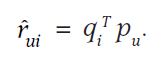



Like other algorithms the recommended stock code are not matching with each other.

In [59]:
SpringMatrix = SpringDataSet.pivot_table(index='StockCode',columns='CustomerID',values='Quantity',aggfunc='sum')
SpringMatrix = SpringMatrix.applymap(lambda x: x if x>0 else 0)
SummerMatrix = SummerDataSet.pivot_table(index='StockCode',columns='CustomerID',values='Quantity',aggfunc='sum')
SummerMatrix = SummerMatrix.applymap(lambda x: x if x>0 else 0)
AutumnMatrix = AutumnDataSet.pivot_table(index='StockCode',columns='CustomerID',values='Quantity',aggfunc='sum')
AutumnMatrix = AutumnMatrix.applymap(lambda x: x if x>0 else 0)
WinterMatrix = WinterDataSet.pivot_table(index='StockCode',columns='CustomerID',values='Quantity',aggfunc='sum')
WinterMatrix = WinterMatrix.applymap(lambda x: x if x>0 else 0)
DfMatrix = df.pivot_table(index='StockCode',columns='CustomerID',values='Quantity',aggfunc='sum')
DfMatrix = DfMatrix.applymap(lambda x: x if x>0 else 0)

In [60]:
def MeanMatrix(matrix):
    R = matrix.as_matrix()
    QuantityMean = np.mean(R, axis = 1)
    R_demeaned = R - QuantityMean.reshape(-1, 1)
    U, sigma, Vt = svds(R_demeaned, k = 50)
    sigma = np.diag(sigma)
    AllItmQty = np.dot(np.dot(U, sigma), Vt) + QuantityMean.reshape(-1, 1)
    preds_df = pd.DataFrame(AllItmQty, columns = matrix.columns)
    return preds_df
    

In [77]:
def recommendItems(StockCode,Matrix, Dataset, num_recommendations=10):
    
    predictions_df=MeanMatrix(Matrix)
    Matrix = Matrix.reset_index()
    StockCodeRowNumber = Matrix.loc[Matrix['StockCode'] == StockCode].index.values.astype(int)[0]
    sorted_user_predictions = predictions_df.iloc[StockCodeRowNumber].sort_values(ascending=False)
    
    
    stock_data = Dataset[Dataset.StockCode == (StockCode)]
    stock_full = (stock_data.sort_values(['Quantity'], ascending=False))
    print('Top 10 recommendation')
    
    recommendations = (Dataset[Dataset['CustomerID'].isin(stock_full['CustomerID'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'CustomerID',
               right_on = 'CustomerID').
         rename(columns = {StockCodeRowNumber: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )
    print(recommendations[['StockCode', 'Description']]  )

#### Overall Dataset

In [78]:
recommendItems(11001,DfMatrix, df, 10)

C:\Users\Vinoth Shankar\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Top 10 recommendation
     StockCode                         Description
8462     22197                      POPCORN HOLDER
9138     23084                  RABBIT NIGHT LIGHT
8310     22991                GIRAFFE WOODEN RULER
8311     21479        WHITE SKULL HOT WATER BOTTLE
8312     22493           PAINT YOUR OWN CANVAS SET
8313     22561         WOODEN SCHOOL COLOURING SET
8461     21430  SET/3 RED GINGHAM ROSE STORAGE BOX
8460     23215    JINGLE BELL HEART ANTIQUE SILVER
8459     22191              IVORY DINER WALL CLOCK
8458     23203           JUMBO BAG DOILEY PATTERNS


#### Spring Dataset

In [63]:
recommendItems(11001,SpringMatrix, SpringDataSet, 10)

C:\Users\Vinoth Shankar\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Top 10 recommendation
    StockCode                          Description
733     22619            SET OF 6 SOLDIER SKITTLES
773     21078      SET/20 STRAWBERRY PAPER NAPKINS
784     23192  BUNDLE OF 3 ALPHABET EXERCISE BOOKS
783     23190    BUNDLE OF 3 SCHOOL EXERCISE BOOKS
782     22425                ENAMEL COLANDER CREAM
781     23091           ZINC HERB GARDEN CONTAINER
780     21246               RED RETROSPOT BIG BOWL
779     23176                ABC TREASURE BOOK BOX
778     23193       BUFFALO BILL TREASURE BOOK BOX
777     23177             TREASURE ISLAND BOOK BOX


#### Summer Dataset

In [64]:
recommendItems(11001,SummerMatrix, SummerDataSet, 10)

C:\Users\Vinoth Shankar\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Top 10 recommendation
     StockCode                        Description
1610     23203          JUMBO BAG DOILEY PATTERNS
1726     23201                 JUMBO BAG ALPHABET
1615     21731      RED TOADSTOOL LED NIGHT LIGHT
1616     84879      ASSORTED COLOUR BIRD ORNAMENT
1617     22139    RETROSPOT TEA SET CERAMIC 11 PC
1718     21915              RED  HARMONICA IN BOX
1719     20972  PINK CREAM FELT CRAFT TRINKET BOX
1720     11001        ASSTD DESIGN RACING CAR PEN
1721     21791  VINTAGE HEADS AND TAILS CARD GAME
1722     21481         FAWN BLUE HOT WATER BOTTLE


#### Autumn Dataset

In [65]:
recommendItems(11001,AutumnMatrix, AutumnDataSet, 10)

C:\Users\Vinoth Shankar\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Top 10 recommendation
     StockCode                          Description
0        15034           PAPER POCKET TRAVELING FAN
4512     22998         TRAVEL CARD WALLET KEEP CALM
4501     23302       KNEELING MAT HOUSEWORK  DESIGN
4502     20914  SET/5 RED RETROSPOT LID GLASS BOWLS
4503     22066               LOVE HEART TRINKET POT
4504     21618       4 WILDFLOWER BOTANICAL CANDLES
4505     21615  4 LAVENDER BOTANICAL DINNER CANDLES
4506     21619          4 VANILLA BOTANICAL CANDLES
4507     21617     4 LILY  BOTANICAL DINNER CANDLES
4508     21616      4 PEAR BOTANICAL DINNER CANDLES


#### Winter Dataset

In [66]:
recommendItems(11001,WinterMatrix, WinterDataSet, 10)

C:\Users\Vinoth Shankar\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Top 10 recommendation
    StockCode                   Description
0       16237          SLEEPING CAT ERASERS
892     22472     TV DINNER TRAY DOLLY GIRL
885     22418        10 COLOUR SPACEBOY PEN
886     20996      JAZZ HEARTS ADDRESS BOOK
887     22203        MILK PAN RED RETROSPOT
888     22752  SET 7 BABUSHKA NESTING BOXES
889     20763              DAISY SKETCHBOOK
890     22030        SWALLOWS GREETING CARD
891     22817            CARD SUKI BIRTHDAY
893     22474       SPACEBOY TV DINNER TRAY


## Analysis

On comparing recommended stock codes across all algorithms. Cosine similarity and Pearson correlation coefficient as a better result. On comparing both these algorithm I could see their results are the same except for the winter dataset which also as a 50% success rate.

## Conclusion

Even though all these four algorithms as their advantage and disadvantage. I could suggest Cosine similarity and Pearson correlation as better suitable for recommending system than the other two algorithms. In the future, we can also do this analysis country wise to get a better result.